<a href="https://colab.research.google.com/github/Pasindu19970808/RemainingUsefulLifePrediction/blob/main/RUL_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import regex as re
from pathlib import Path
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import StandardScaler
from datetime import datetime

https://github.com/keras-team/keras/issues/1761

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
configs = {
    'Data Path' : r'/content/drive/My Drive/Colab Notebooks/RUL Prediction/CMaps',
    'Model Path' : r'/content/drive/My Drive/Colab Notebooks/RUL Prediction/Models'
    # 'Test Data Path' :
}

In [4]:
# re_rul = re.compile(r'RUL_FD(\w+){3}\.txt')
# re_test = re.compile(r'test_FD(\w+){3}\.txt')
# re_train = re.compile(r'train_FD(\w+){3}\.txt')
re_rul = re.compile(r'RUL_FD001.txt')
re_test = re.compile(r'test_FD001.txt')
re_train = re.compile(r'train_FD001.txt')


test_files = [i for i in Path(configs['Data Path']).iterdir() if re_test.match(i.name)]
test_RUL = [i for i in Path(configs['Data Path']).iterdir() if re_rul.match(i.name)]
train_files = [i for i in Path(configs['Data Path']).iterdir() if re_train.match(i.name)]

In [5]:
def split_name(path):
    file_name = path.stem
    return file_name.split('_')[-1]

def split_data_to_unit(data,col_names = None,cols_to_drop = None):
  if cols_to_drop:
    assert col_names != None,"col_names cannot be None"
  for key,grp in data.groupby(0):
      grp = grp.iloc[:,2:].dropna(axis = 1)
      if cols_to_drop:
        grp.columns = col_names
        grp = grp.drop(cols_to_drop,axis = 1)
      grp = grp.to_numpy()
      yield (key,grp)

def create_data_dictionary(files,col_names = None,cols_to_drop = None):
    data_dictionary = {}
    for file in files:
        data = pd.read_csv(file,header = None,delimiter = ' ')
        engine_name = split_name(file)
        key_data = split_data_to_unit(data,col_names,cols_to_drop)
        for key,data in key_data:
            data_dictionary[f'{engine_name}_{key}'] = data
    return data_dictionary

def get_target_data(data_length):
  return np.arange(data_length - 1,-1,-1)

def get_unit_data_split(data,window_length,shift):
  assert window_length <= data.shape[0],"Window length larger than data length"
  data_length = data.shape[0]
  target_data = get_target_data(data_length)
  #make data into a batch,window_length,num_features shape matrix
  num_batches = int(np.floor((data_length - window_length)/shift)) + 1
  data_template = np.zeros(shape = (num_batches,window_length,data.shape[1]))
  target_data_template = np.zeros(shape = (num_batches,1))
  for batch in range(num_batches):
    batch_data = data[batch*shift : (batch*shift) + (window_length),:]
    data_template[batch,:,:] = batch_data
    target_data_template[batch] = target_data[(batch*shift) + (window_length - 1)]
  return data_template,target_data_template

def get_unit_data_test(data,window_length):
  assert window_length <= data.shape[0],"Window length larger than data length"
  last_cycle = data[-window_length:,:]
  return last_cycle

def make_to_array(concat_list):
  batch_number = len(concat_list)
  window_length = concat_list[0].shape[0]
  num_features = concat_list[0].shape[1]
  data_template = np.zeros(shape = (batch_number,window_length,num_features))
  for i,data in enumerate(concat_list):
    data_template[i,:,:] = concat_list[i]
  return data_template

def get_data_split_test(data,window_length,key_names):
  concat_list = []
  for key in key_names:
    unit_data = get_unit_data_test(data[key],window_length)
    concat_list.append(unit_data)
  data = make_to_array(concat_list)
  return data


def get_test_targets(file):
  data = pd.read_csv(file,header = None).to_numpy()
  return data


In [6]:
window_length = 25
shift = 1
concat_list = []
concat_list_targets = []
train_data = create_data_dictionary(train_files)
for key,data in train_data.items():
  x,y = get_unit_data_split(data,window_length,shift)
  concat_list.append(x)
  concat_list_targets.append(y)

In [7]:
complete_ds = np.concatenate(concat_list,axis = 0)
complete_ds_targets = np.concatenate(concat_list_targets,axis = 0)

Checking the distribution of attributes

In [8]:
complete_df = pd.DataFrame(np.reshape(complete_ds,newshape = (complete_ds.shape[0]*complete_ds.shape[1],complete_ds.shape[2])))
complete_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,455775.000000,455775.000000,455775.0,4.557750e+05,455775.000000,455775.000000,455775.000000,4.557750e+05,455775.000000,455775.000000,...,455775.000000,455775.000000,455775.000000,455775.000000,4.557750e+05,455775.000000,455775.0,455775.0,455775.000000,455775.000000
mean,-0.000014,0.000003,100.0,5.186700e+02,642.645127,1590.104907,1408.226487,1.462000e+01,21.609810,553.434982,...,521.470647,2388.091244,8142.893227,8.439276,3.000000e-02,393.100767,2388.0,100.0,38.829357,23.297564
std,0.002187,0.000293,0.0,6.821218e-13,0.460672,5.671694,8.103050,3.552718e-15,0.001366,0.802413,...,0.664990,0.066004,16.044579,0.034137,2.428616e-17,1.424208,0.0,0.0,0.165126,0.098752
min,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,-0.001500,-0.000200,100.0,5.186700e+02,642.320000,1586.200000,1402.330000,1.462000e+01,21.610000,552.900000,...,521.030000,2388.040000,8133.620000,8.414600,3.000000e-02,392.000000,2388.0,100.0,38.720000,23.233200
50%,0.000000,0.000000,100.0,5.186700e+02,642.630000,1589.900000,1407.710000,1.462000e+01,21.610000,553.470000,...,521.500000,2388.090000,8140.600000,8.437600,3.000000e-02,393.000000,2388.0,100.0,38.840000,23.301500
75%,0.001500,0.000300,100.0,5.186700e+02,642.950000,1593.780000,1413.550000,1.462000e+01,21.610000,554.010000,...,521.960000,2388.130000,8148.100000,8.461700,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.367200
max,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


<BarContainer object of 24 artists>

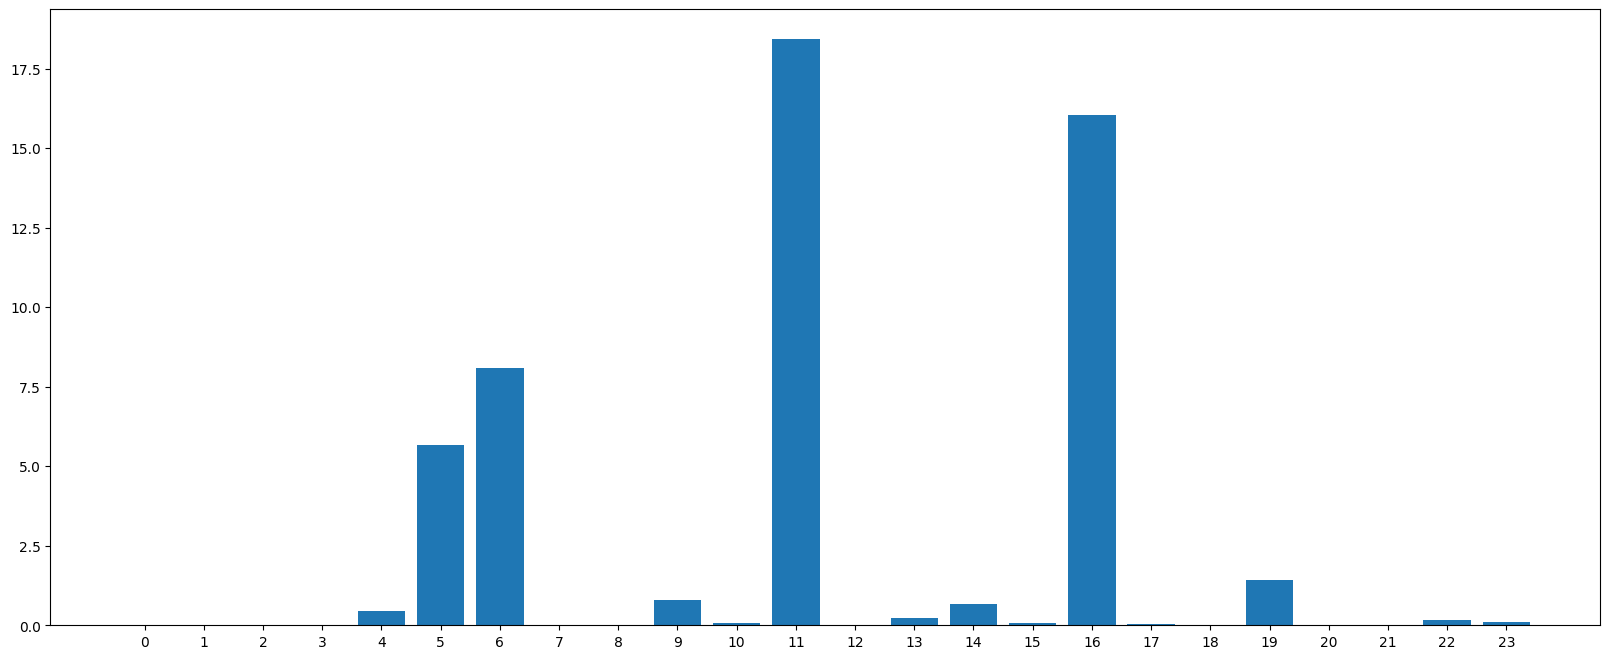

In [9]:
fig,ax = plt.subplots(1,1,figsize = (20,8))
ax.bar(x = complete_df.columns.tolist(),height = complete_df.describe().iloc[2,:].tolist(),tick_label = complete_df.columns.tolist())
# sns.barplot()


Removing unnecessary attributes

In [10]:
col_names = ['op1','op2','op3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13',\
             's14','s15','s16','s17','s18','s19','s20','s21']
col_idx = [0,1,2,3,7,8,12,18,20,21]
cols_to_drop = [col_names[i] for i in col_idx]

Split dataset to train validation splits

In [11]:
window_length = 25
shift = 1
concat_list = []
concat_list_targets = []
train_data = create_data_dictionary(train_files,col_names,cols_to_drop)
for key,data in train_data.items():
  x,y = get_unit_data_split(data,window_length,shift)
  concat_list.append(x)
  concat_list_targets.append(y)

In [12]:
window_length = 25
test_data_raw = create_data_dictionary(test_files,col_names,cols_to_drop)
engine_names = list(set([i.stem.split("_")[1] for i in test_files]))
concat_list_test = []
concat_list_test_targets = []
test_data = {}
test_data_targets = {}
for engine_name in engine_names:
  file = [i for i in test_RUL if engine_name in i.stem][0]
  test_data_targets[engine_name] = get_test_targets(file)
  key_names = [i for i in list(test_data_raw.keys()) if engine_name in i]
  test_data[engine_name] = get_data_split_test(test_data_raw,window_length,key_names)

In [13]:
complete_ds_before_scaling = np.concatenate(concat_list,axis = 0)
complete_ds_targets = np.concatenate(concat_list_targets)

Getting test data for scaling

In [14]:
concat_list_test = [np.reshape(j,newshape = (j.shape[0]*j.shape[1],j.shape[2])) for i,j in test_data.items()]
complete_test_ds_before_scaling = np.concatenate(concat_list_test,axis = 0)
complete_test_ds_targets = test_data_targets['FD001']

In [15]:
complete_test_ds_before_scaling.shape

(2500, 14)

Scaling the data

In [16]:
scaling_complete_ds = np.reshape(complete_ds_before_scaling,newshape = (complete_ds_before_scaling.shape[0]*complete_ds_before_scaling.shape[1],-1))
scaler = StandardScaler()
scaling_complete_ds = scaler.fit_transform(scaling_complete_ds)
complete_ds = np.reshape(scaling_complete_ds,newshape = (complete_ds_before_scaling.shape[0],
                                                         complete_ds_before_scaling.shape[1],
                                                         complete_ds_before_scaling.shape[2]))

In [17]:
#using the scaler from train data on test
scaling_complete_test_ds = scaler.transform(complete_test_ds_before_scaling)
complete_test_ds = np.reshape(scaling_complete_test_ds,newshape = (test_data['FD001'].shape[0],
                                                                   test_data['FD001'].shape[1],
                                                                   test_data['FD001'].shape[2]))

Splitting to Training and Validation

In [18]:
total_indexes = np.arange(0,complete_ds.shape[0],1)
train_X_idx,val_X_idx = train_test_split(total_indexes,test_size = 0.2,random_state = 42,shuffle = True)

In [19]:
train_X = complete_ds[train_X_idx,:,:]
train_Y = complete_ds_targets[train_X_idx]

val_X = complete_ds[val_X_idx,:,:]
val_Y = complete_ds_targets[val_X_idx]

test_X = complete_test_ds
test_Y = complete_test_ds_targets

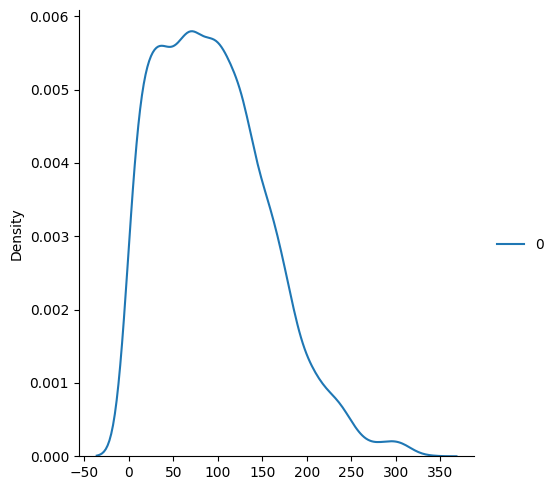

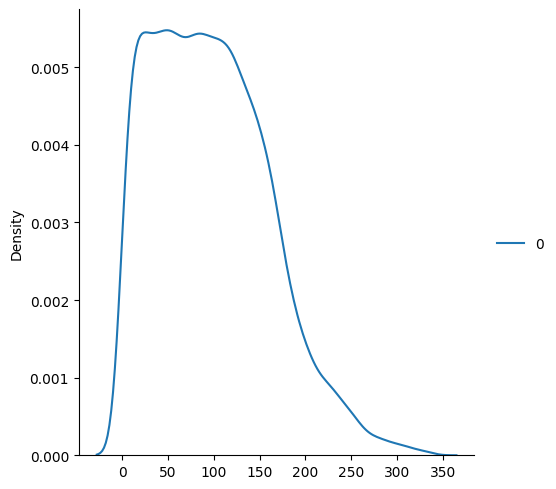

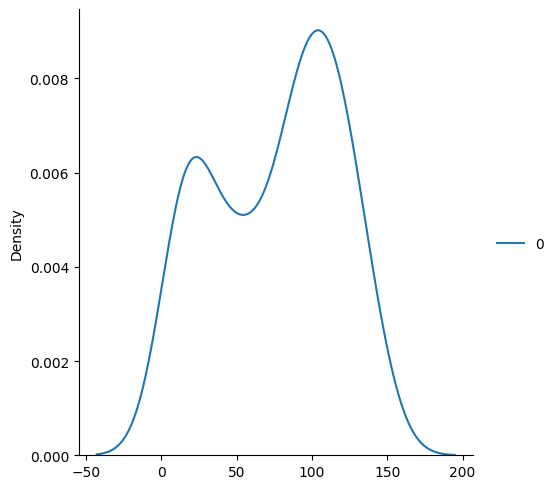

In [20]:
# fig,ax = plt.subplots(1,1,figsize = (10,10))
sns.displot(val_Y,kind = 'kde')
sns.displot(train_Y,kind = 'kde')
sns.displot(test_Y,kind = 'kde')

Distribution between Validation and Training is very similar

In [21]:
class EngineDataset(Dataset):
  def __init__(self,X,y):
    self.X = X
    self.y = y
  def __len__(self):
    return len(self.X)
  def __getitem__(self,index):
    x = self.X[index,:,:]
    #https://discuss.pytorch.org/t/runtimeerror-input-and-hidden-tensors-are-not-the-same-dtype-found-input-tensor-with-double-and-hidden-tensor-with-float/139087/2
    x = torch.from_numpy(x).float()
    y = self.y[index]
    y = torch.from_numpy(y).float()
    return x,y

In [22]:
train_dataset = EngineDataset(train_X,train_Y)
val_dataset = EngineDataset(val_X,val_Y)
test_dataset = EngineDataset(test_X,test_Y)

In [23]:
train_dataloader = DataLoader(train_dataset,batch_size = 16,shuffle = True)
val_dataloader = DataLoader(val_dataset,batch_size = 16,shuffle = True)
test_dataloader = DataLoader(test_dataset,batch_size = 1,shuffle = True)

In [24]:
complete_ds.shape

(18231, 25, 14)

In [40]:
#put this in a train function
#shape of data = [N,25,14]
#https://github.com/pytorch/examples/blob/2639cf050493df9d3cbf065d45e6025733add0f4/imagenet/main.py#L268
def validate(model,val_dataloader,criterion):
  val_loss = []
  for i,j in enumerate(val_dataloader):
    X = j[0].to(device)
    true_rul = j[1].to(device)

    pred_rul = model(X)
    loss = criterion(pred_rul,true_rul)

    # val_loss += loss.item()
    val_loss.append(loss.item())
  average_loss = np.mean(val_loss)
  return average_loss,model

def train_one_epoch(model,train_dataloader,optimizer,criterion):
  running_loss = 0
  batches_loss = []
  for i,j in enumerate(train_dataloader):
      X = j[0].to(device)
      true_rul = j[1].to(device)
      optimizer.zero_grad()

      pred_rul = model(X)
      loss = criterion(pred_rul,true_rul)

      loss.backward()
      optimizer.step()
      # running_loss += loss.item()
      # if i % 100 == 99:
      batches_loss.append(loss.item()) #average loss batch
        # print(f'Batch {i + 1} loss {last_loss}')
  average_epoch_train_loss = np.mean(batches_loss)
  return average_epoch_train_loss,model

def train(model,epoch_number,train_dataloader,val_dataloader,optimizer,criterion,
          scheduler = None,scheduling_epoch = None,scheduling_interval = 10,save_checkpoint = False,save_path = None):
  epoch_train_loss = []
  epoch_val_loss = []
  best_val_loss = 1000000
  for epoch in range(epoch_number):
    model.train(True)

    avg_train_loss,model = train_one_epoch(model,
                                     train_dataloader,
                                     optimizer,criterion)


    model.eval()
    with torch.no_grad():
      val_loss = []
      for i,j in enumerate(val_dataloader):
        X = j[0].to(device)
        true_rul = j[1].to(device)

        pred_rul = model(X)
        loss = criterion(pred_rul,true_rul)
        val_loss.append(loss.item())#adding average batch loss
      #average loss over all batches
      avg_val_loss = np.mean(val_loss)
      #validation loss for epoch
      epoch_val_loss.append(avg_val_loss)

    if scheduler:
      if (epoch + 1)>= scheduling_epoch:
        if ((epoch + 1) - scheduling_epoch)%scheduling_interval == 0:
          print("Changing LR")
          print(f'Old LR : {optimizer.param_groups[0]["lr"]}')
          scheduler.step()
          print(f'New LR : {optimizer.param_groups[0]["lr"]}')

    if save_checkpoint:
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        model_path = f'{save_path}/model_best.pt'
        torch.save(model.state_dict(), model_path)

    print(f"--------Epoch {epoch}--------")
    print(f"--------Epoch Training MSE Loss :{avg_train_loss:.2f} Epoch Training RMSE Loss: {np.sqrt(avg_train_loss):.2f}-------")
    print(f"--------Epoch Validation MSE Loss :{avg_val_loss:.2f} Epoch Validation RMSE Loss: {np.sqrt(avg_val_loss):.2f}-----------")
    epoch_train_loss.append(avg_train_loss)

  return model,epoch_train_loss,epoch_val_loss

def plot_val_train_loss_curves(loss_dict,epoch_number):
  fig,ax = plt.subplots(1,1,figsize = (10,10))
  for key in loss_dict:
    loss_train = loss_dict[key][0]
    loss_val = loss_dict[key][1]
    ax.plot(list(range(1,epoch_number+1)),loss_train,color = 'b',label = f"Train Loss {key}")
    ax.plot(list(range(1,epoch_number+1)),loss_val,color = 'r',label = f"Val Loss {key}")
  ax.legend()
  ax.set_ylabel('Loss')
  ax.set_xlabel('Epoch Number')
  return ax
  # ax.set_ylim(bottom = 0,top = 10000)

Model Architeture 1:

BiLSTM

In [ ]:
class modelBiLSTM(nn.Module):
  def __init__(self,input_size,hidden_size,dropout = 0.5):
    super(modelBiLSTM,self).__init__()
    #In bidirectional LSTM the output hidden_states h_n(second item in tupled)
    #contains the final hidden state from both directions for each item in batch
    self.lstm = nn.LSTM(input_size = input_size,
                        hidden_size = hidden_size,
                        batch_first = True,
                        bidirectional = True)
    self.bnorm1 = nn.BatchNorm1d(hidden_size*2)
    self.linear1 = nn.Linear(in_features = hidden_size*2,out_features = hidden_size)
    self.bn2 = nn.BatchNorm1d(hidden_size)
    self.drop = nn.Dropout(dropout)
    self.linear2 = nn.Linear(in_features = hidden_size,out_features = 1)
  def forward(self,X):
    x = self.lstm(X)
    #combines the final forward and backward hidden states
    x = torch.concat((x[1][0][0,:,:],x[1][0][1,:,:]),axis = 1)
    x = self.bnorm1(x)
    x = self.linear1(x)
    x = self.bn2(x)
    x = self.drop(x)
    x = self.linear2(x)
    return x

Function to Plot

https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

Trying for 10 epochs with LR = 1E-3 as first attempt

In [ ]:
epoch_number = 20
model = modelBiLSTM(14,7,0).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
criterion = nn.MSELoss()
model,epoch_train_loss,epoch_val_loss = train(model,epoch_number,train_dataloader,val_dataloader,optimizer,criterion)

In [ ]:
plot_val_train_loss_curves({f'LR {1E-3}':(epoch_train_loss,epoch_val_loss)},20)

The model capacit seems to be too low.

Trying with larger hidden size and linear size

In [ ]:
epoch_number = 60
model = modelBiLSTM(14,14,0).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
criterion = nn.MSELoss()
model,epoch_train_loss,epoch_val_loss = train(model,epoch_number,train_dataloader,val_dataloader,optimizer,criterion)

In [ ]:
plot_val_train_loss_curves({f'LR {1E-3}':(epoch_train_loss[2:],epoch_val_loss[2:])},58)

The model is of low capacity as it takes a lot of epochs to reduce loss

In [ ]:
class modelBiLSTM2(nn.Module):
  def __init__(self,input_size,hidden_size,dropout = 0.5):
    super(modelBiLSTM2,self).__init__()
    #In bidirectional LSTM the output hidden_states h_n(second item in tupled)
    #contains the final hidden state from both directions for each item in batch
    self.lstm = nn.LSTM(input_size = input_size,
                        hidden_size = hidden_size,
                        batch_first = True,
                        bidirectional = True)
    self.block1 = nn.Sequential(
        nn.BatchNorm1d(hidden_size*2),
        # nn.ReLU()
    )
    self.block2 = nn.Sequential(
        nn.Linear(in_features = hidden_size*2,out_features = hidden_size),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU()
    )
    self.linear2 = nn.Linear(in_features = hidden_size,out_features = 1)
  def forward(self,X):
    x = self.lstm(X)
    #combines the final forward and backward hidden states
    x = torch.concat((x[1][0][0,:,:],x[1][0][1,:,:]),axis = 1)
    x = self.block1(x)
    x = self.block2(x)
    x = self.linear2(x)
    return x

In [ ]:
epoch_number = 60
model = modelBiLSTM2(14,14,0).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
criterion = nn.MSELoss()
model,epoch_train_loss,epoch_val_loss = train(model,epoch_number,train_dataloader,val_dataloader,optimizer,criterion)

In [ ]:
plot_val_train_loss_curves({f'LR {1E-3}':(epoch_train_loss[2:],epoch_val_loss[2:])},58)

In [ ]:
epoch_number = 100
model = modelBiLSTM2(14,14,0).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
criterion = nn.MSELoss()
model,epoch_train_loss,epoch_val_loss = train(model,epoch_number,train_dataloader,val_dataloader,optimizer,criterion)

In [ ]:
plot_val_train_loss_curves({f'LR {1E-3}':(epoch_train_loss[2:],epoch_val_loss[2:])},98)

Training Plateaus around 60 Epochs.

The model is slow and seems to be under capacity.

As a final attempt use a training scheduler at 60 epochs.

Check This : https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#reducelronplateau

In [ ]:
epoch_number = 100
model = modelBiLSTM2(14,14,0).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = nn.MSELoss()
model,epoch_train_loss,epoch_val_loss = train(model,epoch_number,train_dataloader,val_dataloader,optimizer,criterion,scheduler,60,10)

In [ ]:
plot_val_train_loss_curves({f'LR {1E-3}':(epoch_train_loss[2:],epoch_val_loss[2:])},98)

In [27]:
class modelBiLSTM3(nn.Module):
  def __init__(self,input_size,hidden_size,dropout = 0.5):
    super(modelBiLSTM3,self).__init__()
    #In bidirectional LSTM the output hidden_states h_n(second item in tupled)
    #contains the final hidden state from both directions for each item in batch
    self.lstm = nn.LSTM(input_size = input_size,
                        hidden_size = hidden_size,
                        batch_first = True,
                        bidirectional = True)
    self.block1 = nn.Sequential(
        nn.BatchNorm1d(hidden_size*2),
        # nn.ReLU()
    )
    self.block2 = nn.Sequential(
        nn.Linear(in_features = hidden_size*2,out_features = hidden_size),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU()
    )
    self.block3 = nn.Sequential(
        nn.Linear(in_features = hidden_size,out_features = 128),
        nn.BatchNorm1d(128),
        nn.ReLU()
    )
    self.linear2 = nn.Linear(in_features = 128,out_features = 1)
  def forward(self,X):
    x = self.lstm(X)
    #combines the final forward and backward hidden states
    x = torch.concat((x[1][0][0,:,:],x[1][0][1,:,:]),axis = 1)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.linear2(x)
    return x

In [ ]:
epoch_number = 50
model = modelBiLSTM3(14,128,0).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = nn.MSELoss()
model,epoch_train_loss,epoch_val_loss = train(model,epoch_number,train_dataloader,val_dataloader,optimizer,criterion)

In [ ]:
plot_val_train_loss_curves({f'LR {1E-3}':(epoch_train_loss[2:],epoch_val_loss[2:])},48)

Using this for Best Model

In [28]:
epoch_number = 100
model = modelBiLSTM3(14,128,0).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
save_path = r'/content/drive/My Drive/Colab Notebooks/RUL Prediction/BiLSTM3'
criterion = nn.MSELoss()
model,epoch_train_loss,epoch_val_loss = train(model,epoch_number,train_dataloader,val_dataloader,optimizer,criterion,scheduler,50,10,True,save_path)

--------Epoch 0--------
--------Epoch Training MSE Loss :5033.25 Epoch Training RMSE Loss: 70.95-------
--------Epoch Validation MSE Loss :1156.99 Epoch Validation RMSE Loss: 34.01-----------
--------Epoch 1--------
--------Epoch Training MSE Loss :1323.42 Epoch Training RMSE Loss: 36.38-------
--------Epoch Validation MSE Loss :1052.71 Epoch Validation RMSE Loss: 32.45-----------
--------Epoch 2--------
--------Epoch Training MSE Loss :1199.47 Epoch Training RMSE Loss: 34.63-------
--------Epoch Validation MSE Loss :1472.27 Epoch Validation RMSE Loss: 38.37-----------
--------Epoch 3--------
--------Epoch Training MSE Loss :1131.58 Epoch Training RMSE Loss: 33.64-------
--------Epoch Validation MSE Loss :944.45 Epoch Validation RMSE Loss: 30.73-----------
--------Epoch 4--------
--------Epoch Training MSE Loss :1056.36 Epoch Training RMSE Loss: 32.50-------
--------Epoch Validation MSE Loss :911.79 Epoch Validation RMSE Loss: 30.20-----------
--------Epoch 5--------
--------Epoch Trai

<Axes: xlabel='Epoch Number', ylabel='Loss'>

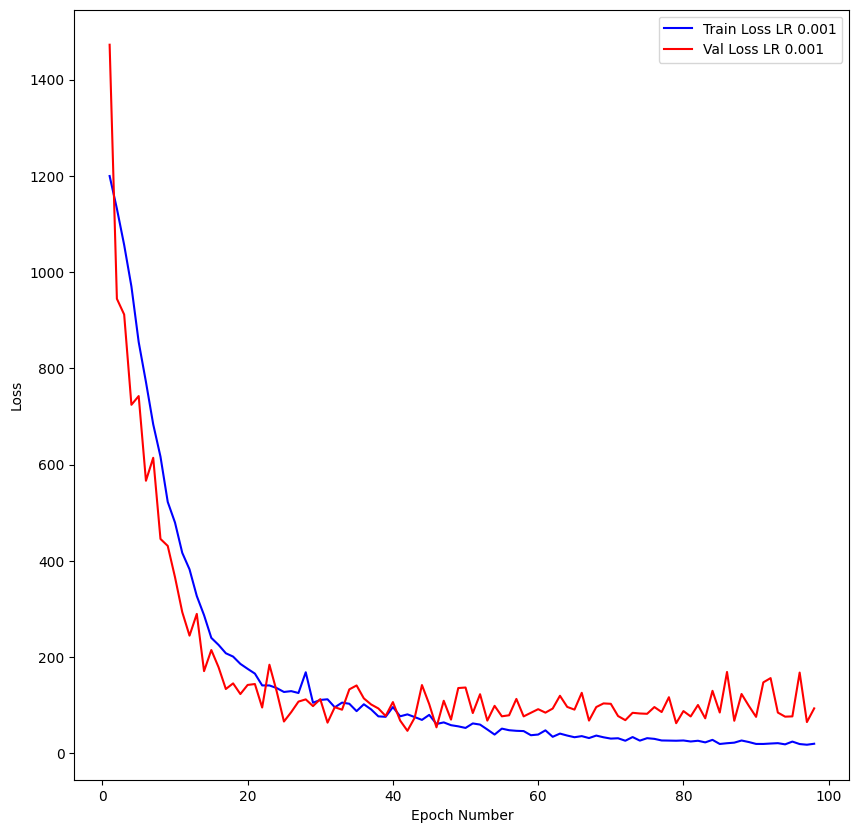

In [29]:
plot_val_train_loss_curves({f'LR {1E-3}':(epoch_train_loss[2:],epoch_val_loss[2:])},98)

Load Model and Evaluate on Test Set

In [32]:
#model Path
PATH = r'/content/drive/My Drive/Colab Notebooks/RUL Prediction/BiLSTM3/model_best.pt'
model = modelBiLSTM3(14,128,0).to(device)
model.load_state_dict(torch.load(PATH))
model.eval()
criterion = nn.MSELoss()
running_loss = 0
for i,j in enumerate(test_dataloader):
  x = j[0].to(device)
  true_rul = j[1].to(device)
  pred_rul = model(x)
  loss = criterion(pred_rul,true_rul)
  running_loss += loss.item()
print(f"Test Loss : {np.sqrt(running_loss/(i + 1))}")

Test Loss : 30.044702386896258


As above is showing signs of overfitting.

Hence add in dropout layers and a slight weight decay

In [41]:
class modelBiLSTM4(nn.Module):
  def __init__(self,input_size,hidden_size,dropout = 0.5):
    super(modelBiLSTM4,self).__init__()
    #In bidirectional LSTM the output hidden_states h_n(second item in tupled)
    #contains the final hidden state from both directions for each item in batch
    self.lstm = nn.LSTM(input_size = input_size,
                        hidden_size = hidden_size,
                        batch_first = True,
                        bidirectional = True)
    self.block1 = nn.Sequential(
        nn.BatchNorm1d(hidden_size*2),
        # nn.ReLU()
    )
    self.block2 = nn.Sequential(
        nn.Linear(in_features = hidden_size*2,out_features = hidden_size),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU()
    )
    self.drop1 = nn.Dropout(0.25)
    self.block3 = nn.Sequential(
        nn.Linear(in_features = hidden_size,out_features = 128),
        nn.BatchNorm1d(128),
        nn.ReLU()
    )
    self.drop2 = nn.Dropout(0.15)
    self.linear2 = nn.Linear(in_features = 128,out_features = 1)
  def forward(self,X):
    x = self.lstm(X)
    #combines the final forward and backward hidden states
    x = torch.concat((x[1][0][0,:,:],x[1][0][1,:,:]),axis = 1)
    x = self.block1(x)
    x = self.block2(x)
    x = self.drop1(x)
    x = self.block3(x)
    x = self.drop2(x)
    x = self.linear2(x)
    return x

In [42]:
epoch_number = 100
model = modelBiLSTM4(14,128,0).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001,weight_decay = 0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = nn.MSELoss()
save_path = r'/content/drive/My Drive/Colab Notebooks/RUL Prediction/BiLSTM4'
model,epoch_train_loss,epoch_val_loss = train(model,epoch_number,train_dataloader,val_dataloader,optimizer,criterion,scheduler,50,10,True,save_path)

--------Epoch 0--------
--------Epoch Training MSE Loss :5027.07 Epoch Training RMSE Loss: 70.90-------
--------Epoch Validation MSE Loss :1243.55 Epoch Validation RMSE Loss: 35.26-----------
--------Epoch 1--------
--------Epoch Training MSE Loss :1400.65 Epoch Training RMSE Loss: 37.43-------
--------Epoch Validation MSE Loss :1024.04 Epoch Validation RMSE Loss: 32.00-----------
--------Epoch 2--------
--------Epoch Training MSE Loss :1203.92 Epoch Training RMSE Loss: 34.70-------
--------Epoch Validation MSE Loss :926.79 Epoch Validation RMSE Loss: 30.44-----------
--------Epoch 3--------
--------Epoch Training MSE Loss :1115.89 Epoch Training RMSE Loss: 33.40-------
--------Epoch Validation MSE Loss :939.54 Epoch Validation RMSE Loss: 30.65-----------
--------Epoch 4--------
--------Epoch Training MSE Loss :1042.71 Epoch Training RMSE Loss: 32.29-------
--------Epoch Validation MSE Loss :774.26 Epoch Validation RMSE Loss: 27.83-----------
--------Epoch 5--------
--------Epoch Train

<Axes: xlabel='Epoch Number', ylabel='Loss'>

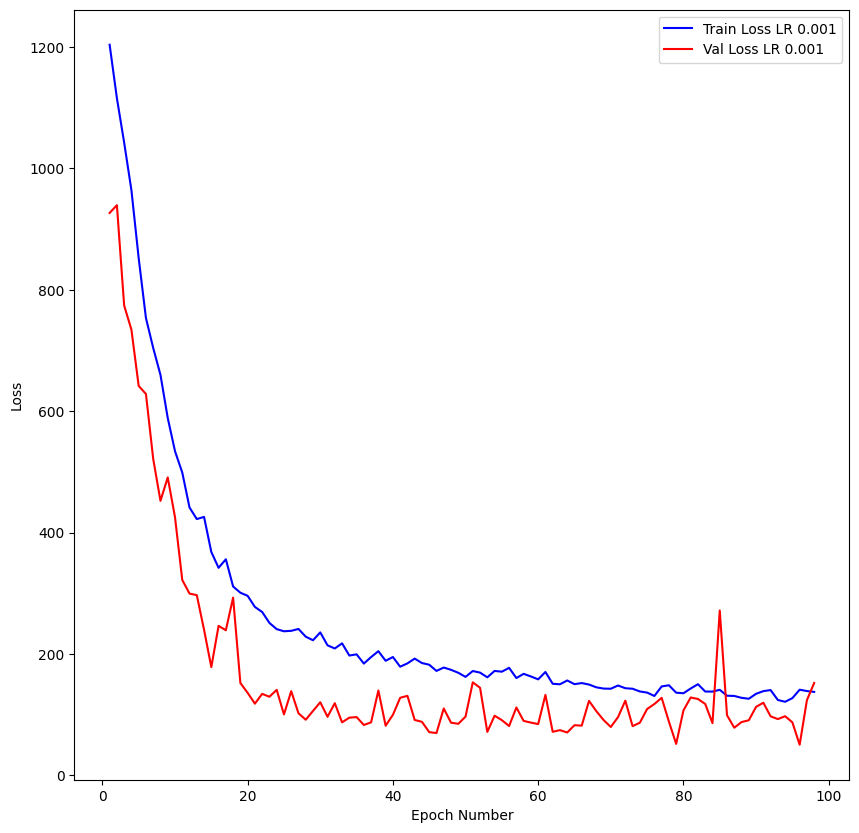

In [43]:
plot_val_train_loss_curves({f'LR {1E-3}':(epoch_train_loss[2:],epoch_val_loss[2:])},98)

In [44]:
#model Path
PATH = r'/content/drive/My Drive/Colab Notebooks/RUL Prediction/BiLSTM4/model_best.pt'
model = modelBiLSTM4(14,128,0).to(device)
model.load_state_dict(torch.load(PATH))
model.eval()
criterion = nn.MSELoss()
running_loss = 0
for i,j in enumerate(test_dataloader):
  x = j[0].to(device)
  true_rul = j[1].to(device)
  pred_rul = model(x)
  loss = criterion(pred_rul,true_rul)
  running_loss += loss.item()
print(f"Test Loss : {np.sqrt(running_loss/(i + 1))}")

Test Loss : 27.406897984799404


In [45]:
class modelBiLSTM5(nn.Module):
  def __init__(self,input_size,hidden_size,dropout = 0.5):
    super(modelBiLSTM5,self).__init__()
    #In bidirectional LSTM the output hidden_states h_n(second item in tupled)
    #contains the final hidden state from both directions for each item in batch
    self.lstm = nn.LSTM(input_size = input_size,
                        hidden_size = hidden_size,
                        batch_first = True,
                        bidirectional = True)
    self.block1 = nn.Sequential(
        nn.BatchNorm1d(hidden_size*2),
        # nn.ReLU()
    )
    self.block2 = nn.Sequential(
        nn.Linear(in_features = hidden_size*2,out_features = hidden_size),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU()
    )
    # self.drop1 = nn.Dropout(0)
    self.block3 = nn.Sequential(
        nn.Linear(in_features = hidden_size,out_features = 128),
        nn.BatchNorm1d(128),
        nn.ReLU()
    )
    self.drop2 = nn.Dropout(0.25)
    self.linear2 = nn.Linear(in_features = 128,out_features = 1)
  def forward(self,X):
    x = self.lstm(X)
    #combines the final forward and backward hidden states
    x = torch.concat((x[1][0][0,:,:],x[1][0][1,:,:]),axis = 1)
    x = self.block1(x)
    x = self.block2(x)
    # x = self.drop1(x)
    x = self.block3(x)
    x = self.drop2(x)
    x = self.linear2(x)
    return x

In [46]:
epoch_number = 100
model = modelBiLSTM5(14,128,0).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001,weight_decay = 0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = nn.MSELoss()
save_path = r'/content/drive/My Drive/Colab Notebooks/RUL Prediction/BiLSTM5'
model,epoch_train_loss,epoch_val_loss = train(model,epoch_number,train_dataloader,val_dataloader,optimizer,criterion,scheduler,50,10,True,save_path)

--------Epoch 0--------
--------Epoch Training MSE Loss :5676.66 Epoch Training RMSE Loss: 75.34-------
--------Epoch Validation MSE Loss :1158.22 Epoch Validation RMSE Loss: 34.03-----------
--------Epoch 1--------
--------Epoch Training MSE Loss :1359.66 Epoch Training RMSE Loss: 36.87-------
--------Epoch Validation MSE Loss :1069.95 Epoch Validation RMSE Loss: 32.71-----------
--------Epoch 2--------
--------Epoch Training MSE Loss :1263.90 Epoch Training RMSE Loss: 35.55-------
--------Epoch Validation MSE Loss :1063.45 Epoch Validation RMSE Loss: 32.61-----------
--------Epoch 3--------
--------Epoch Training MSE Loss :1148.59 Epoch Training RMSE Loss: 33.89-------
--------Epoch Validation MSE Loss :1039.29 Epoch Validation RMSE Loss: 32.24-----------
--------Epoch 4--------
--------Epoch Training MSE Loss :1112.37 Epoch Training RMSE Loss: 33.35-------
--------Epoch Validation MSE Loss :958.11 Epoch Validation RMSE Loss: 30.95-----------
--------Epoch 5--------
--------Epoch Tra

<Axes: xlabel='Epoch Number', ylabel='Loss'>

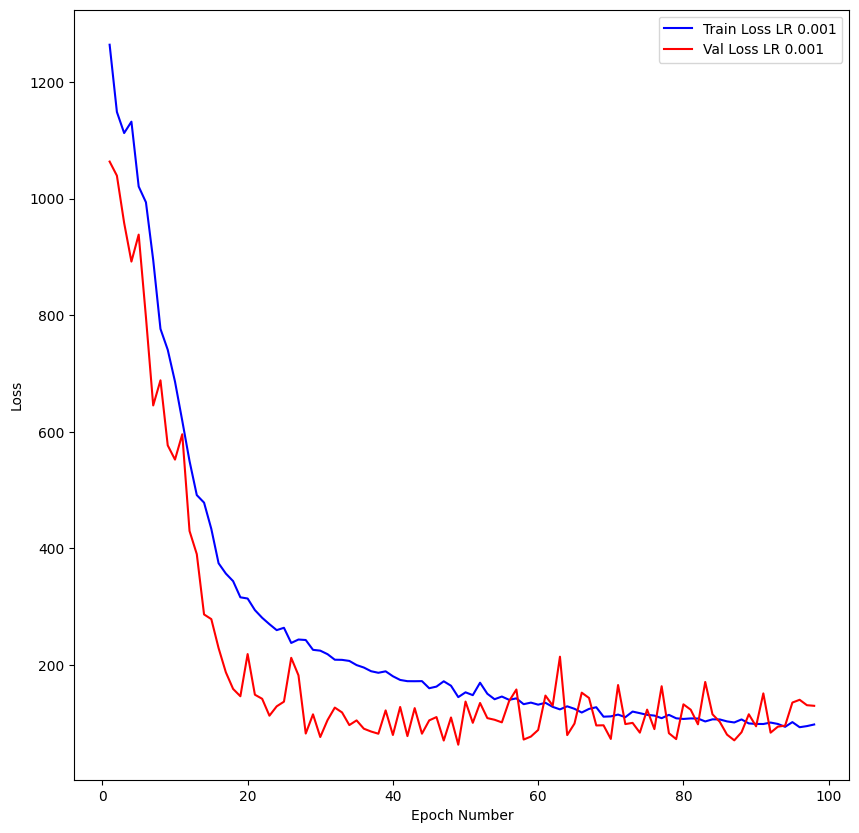

In [47]:
plot_val_train_loss_curves({f'LR {1E-3}':(epoch_train_loss[2:],epoch_val_loss[2:])},98)

In [48]:
#model Path
PATH = r'/content/drive/My Drive/Colab Notebooks/RUL Prediction/BiLSTM5/model_best.pt'
model = modelBiLSTM5(14,128,0).to(device)
model.load_state_dict(torch.load(PATH))
model.eval()
criterion = nn.MSELoss()
running_loss = 0
for i,j in enumerate(test_dataloader):
  x = j[0].to(device)
  true_rul = j[1].to(device)
  pred_rul = model(x)
  loss = criterion(pred_rul,true_rul)
  running_loss += loss.item()
print(f"Test Loss : {np.sqrt(running_loss/(i + 1))}")

Test Loss : 30.525704600487753


In [49]:
class modelBiLSTM6(nn.Module):
  def __init__(self,input_size,hidden_size,dropout = 0.5):
    super(modelBiLSTM6,self).__init__()
    #In bidirectional LSTM the output hidden_states h_n(second item in tupled)
    #contains the final hidden state from both directions for each item in batch
    self.hidden_size = hidden_size
    self.block3_out = hidden_size/2
    self.lstm = nn.LSTM(input_size = input_size,
                        hidden_size = hidden_size,
                        batch_first = True,
                        bidirectional = True)
    self.lstm2 = nn.LSTM(input_size = hidden_size*2,
                        hidden_size = hidden_size*2,
                        batch_first = True)
    self.block1 = nn.Sequential(
        nn.BatchNorm1d(hidden_size*2),
        # nn.ReLU()
    )
    self.block2 = nn.Sequential(
        nn.Linear(in_features = hidden_size*2,out_features = hidden_size),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU()
    )
    # self.drop1 = nn.Dropout(0)
    self.block3 = nn.Sequential(
        nn.Linear(in_features = hidden_size,out_features = int(hidden_size/2)),
        nn.BatchNorm1d(int(hidden_size/2)),
        nn.ReLU()
    )
    self.drop2 = nn.Dropout(0.25)
    self.linear2 = nn.Linear(in_features = int(hidden_size/2),out_features = 1)
  def forward(self,X):
    x = self.lstm(X)
    #combining the corresponding time steps of forward and backward
    forward = x[0][:,:,:self.hidden_size]
    backward = x[0][:,:,self.hidden_size:]
    backward = torch.flip(backward,[1])
    x = torch.cat((forward,torch.flip(backward,[1])),dim = 2)
    #combines the final forward and backward hidden states
    # x = torch.concat((x[1][0][0,:,:],x[1][0][1,:,:]),axis = 1)
    x = self.lstm2(x)[1][0]
    x = x.squeeze()
    x = self.block1(x)
    x = self.block2(x)
    # x = self.drop1(x)
    x = self.block3(x)
    x = self.drop2(x)
    x = self.linear2(x)
    return x

In [50]:
epoch_number = 100
model = modelBiLSTM6(14,256,0).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001,weight_decay = 0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = nn.MSELoss()
save_path = r'/content/drive/My Drive/Colab Notebooks/RUL Prediction/BiLSTM6'
model,epoch_train_loss,epoch_val_loss = train(model,epoch_number,train_dataloader,val_dataloader,optimizer,criterion,scheduler,50,10,True,save_path)

--------Epoch 0--------
--------Epoch Training MSE Loss :5378.31 Epoch Training RMSE Loss: 73.34-------
--------Epoch Validation MSE Loss :1478.42 Epoch Validation RMSE Loss: 38.45-----------
--------Epoch 1--------
--------Epoch Training MSE Loss :1604.70 Epoch Training RMSE Loss: 40.06-------
--------Epoch Validation MSE Loss :1270.57 Epoch Validation RMSE Loss: 35.65-----------
--------Epoch 2--------
--------Epoch Training MSE Loss :1463.68 Epoch Training RMSE Loss: 38.26-------
--------Epoch Validation MSE Loss :1725.97 Epoch Validation RMSE Loss: 41.54-----------
--------Epoch 3--------
--------Epoch Training MSE Loss :1350.03 Epoch Training RMSE Loss: 36.74-------
--------Epoch Validation MSE Loss :1136.08 Epoch Validation RMSE Loss: 33.71-----------
--------Epoch 4--------
--------Epoch Training MSE Loss :1159.17 Epoch Training RMSE Loss: 34.05-------
--------Epoch Validation MSE Loss :996.89 Epoch Validation RMSE Loss: 31.57-----------
--------Epoch 5--------
--------Epoch Tra

<Axes: xlabel='Epoch Number', ylabel='Loss'>

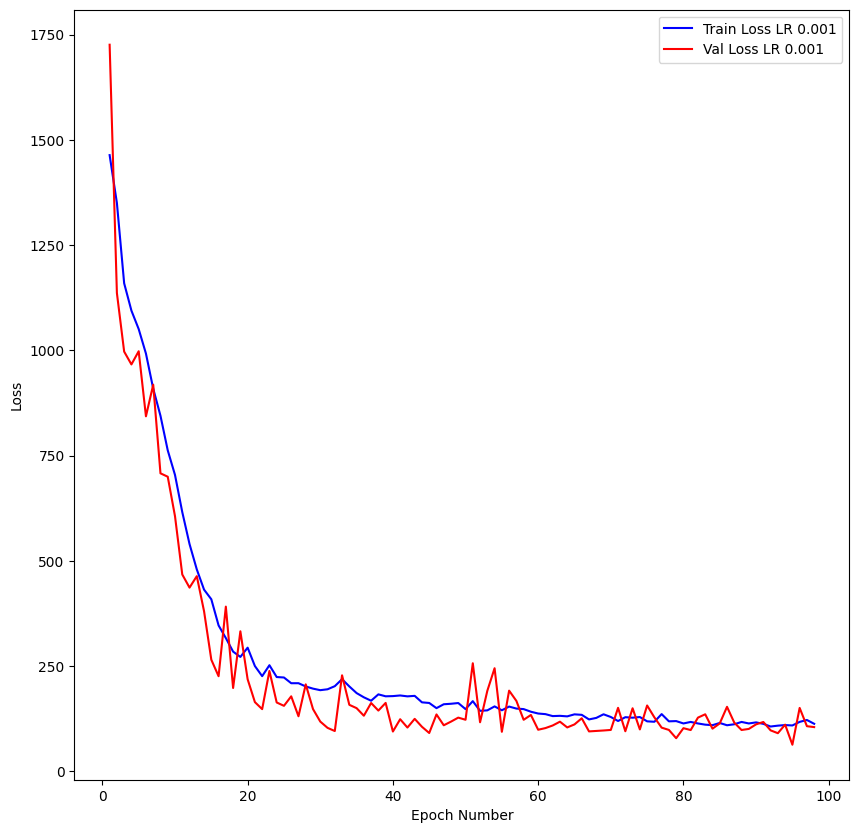

In [51]:
plot_val_train_loss_curves({f'LR {1E-3}':(epoch_train_loss[2:],epoch_val_loss[2:])},98)

In [57]:
#model Path
PATH = r'/content/drive/My Drive/Colab Notebooks/RUL Prediction/BiLSTM6/model_best.pt'
model = modelBiLSTM6(14,256,0).to(device)
model.load_state_dict(torch.load(PATH))
model.eval()
criterion = nn.MSELoss()
running_loss = 0
test_dataloader_bilstm6 = DataLoader(test_dataset,batch_size = 2,shuffle = True)
for i,j in enumerate(test_dataloader_bilstm6):
  x = j[0].to(device)
  true_rul = j[1].to(device)
  pred_rul = model(x)
  loss = criterion(pred_rul,true_rul)
  running_loss += loss.item()
print(f"Test Loss : {np.sqrt(running_loss/(i + 1))}")

Test Loss : 24.102821875117353


In [56]:
i

49